# Data analysis of crime investigations in Mexico City


## Used libraries

In [3]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
import json
from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer, all_palettes, small_palettes,Inferno
from tqdm import tqdm_notebook
import unicodedata
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np


     |████████████████████████████████| 921kB 9.3MB/s 
     |████████████████████████████████| 10.1MB 30.4MB/s 
     |████████████████████████████████| 11.9MB 39.2MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=d8f5b3c2e8b0b718d38e58351e45bf8d0101c81d07dbebf81567d4700454fbcc
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Reading CSVs

Crime investigations database obtained from [here](https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico/information/?disjunctive.delito&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6ImNhcnBldGFzLWRlLWludmVzdGlnYWNpb24tcGdqLWRlLWxhLWNpdWRhZC1kZS1tZXhpY28iLCJvcHRpb25zIjp7ImRpc2p1bmN0aXZlLmRlbGl0byI6dHJ1ZX19LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjNjZjMmE1In1dLCJ4QXhpcyI6ImFvX2hlY2hvcyIsIm1heHBvaW50cyI6NTAsInNvcnQiOiIifV0sInRpbWVzY2FsZSI6IiIsImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9&disjunctive.ao_hechos)

In [13]:
df=pd.read_csv('/content/drive/My Drive/crimen.txt', sep=';')
df.head()

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalia,agencia,unidad_investigacion,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,calle_hechos,calle_hechos2,longitud,latitud,geopoint
0,2019.0,Mayo,2019-05-08 11:40,LESIONES INTENCIONALES POR ARMA BLANCA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN IZTAPALAPA,IZP-9,UI-2SD,IZTAPALAPA,REFORMA POLÍTICA,2019,Mayo,2019-05-08 17:04,ERMITA IZTAPALAPA,REFORMA AERONAUTICA,-99.027960,19.344355,"19.3443550987,-99.0279603801"
1,2019.0,Mayo,2019-05-07 22:00,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,JUZGADOS FAMILIARES,75TER,2 S/D,COYOACAN,CULHUACÁN CTM SECCIÓN IX,2019,Mayo,2019-05-08 17:26,1ER RETORNO DE ROSARIO CASTELLANOS,NaN,-99.104355,19.309442,"19.3094420972,-99.1043554003"
2,2019.0,Mayo,2019-05-08 16:10,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN MAGDALENA CONTRERAS,MC-2,UI-2CD,LA MAGDALENA CONTRERAS,SAN NICOLÁS TOTOLAPAN,2019,Mayo,2019-05-08 17:32,PRIVADA CAPULINES,JACARANDAS,-99.245472,19.291128,"19.2911281429,-99.2454718567"
3,2019.0,Mayo,2019-05-08 13:30,ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN XOCHIMILCO,XO-2,UI-1SD,XOCHIMILCO,SAN LORENZO ATEMOAYA,2019,Mayo,2019-05-08 17:32,AV. 16 DE SEPTIEMBRE,CAMINO VIEJO A SAN LUCAS,-99.104717,19.248153,"19.2481529978,-99.1047174999"
4,2019.0,Mayo,2019-05-07 16:00,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN AZCAPOTZALCO,AZ-4,UI-2SD,AZCAPOTZALCO,CENTRO DE AZCAPOTZALCO,2019,Mayo,2019-05-08 17:33,ESPERANZA,BELISARIO DOMINGUEZ Y RAYON,-99.184611,19.482147,"19.4821468317,-99.1846107077"


Geojson for Mexico city obtained from [here](https://datos.cdmx.gob.mx/explore/dataset/alcaldias/map/?location=10,19.32072,-99.15261)

In [6]:
df2=gpd.read_file('/content/drive/My Drive/alcaldias.geojson.json')
df2['nomgeo']=df2['nomgeo'].str.upper()
df2.head(20)

,cvegeo,nomgeo,cve_mun,cve_ent,geometry
0,09012,TLALPAN,012,09,"POLYGON ((-99.19629 19.30228, -99.19595 19.302..."
1,09017,VENUSTIANO CARRANZA,017,09,"POLYGON ((-99.10895 19.45273, -99.10889 19.452..."
2,09002,AZCAPOTZALCO,002,09,"POLYGON ((-99.18231 19.50748, -99.18229 19.507..."
3,09007,IZTAPALAPA,007,09,"POLYGON ((-99.05813 19.40072, -99.05814 19.400..."
4,09006,IZTACALCO,006,09,"POLYGON ((-99.05584 19.42196, -99.05589 19.421..."
5,09016,MIGUEL HIDALGO,016,09,"POLYGON ((-99.19058 19.46794, -99.19066 19.465..."
6,09008,LA MAGDALENA CONTRERAS,008,09,"POLYGON ((-99.20859 19.33610, -99.20867 19.335..."
7,09003,COYOACÁN,003,09,"POLYGON ((-99.13923 19.35687, -99.13772 19.356..."
8,09009,MILPA ALTA,009,09,"POLYGON ((-98.99723 19.22731, -98.99745 19.227..."
9,09015,CUAUHTÉMOC,015,09,"POLYGON ((-99.12919 19.46247, -99.12884 19.462..."


## Data cleaning


In [7]:
def elimina_tildes(cadena):#Fixes the strings so that thry are on the same format on both data frames
  s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
  return s
    
df2['nomgeo']=df2['nomgeo'].apply(elimina_tildes)

#Poblation data obtained from the INEGI, the most current data is from 2015
pob=(677104, 427263, 400161, 1827868, 390348, 364439, 243886, 608479, 137927, 532553, 749982, 415933, 361593, 417416, 199244, 1164477)

df2['poblacion']=pob

df2.head()

,cvegeo,nomgeo,cve_mun,cve_ent,geometry,poblacion
0,09012,TLALPAN,012,09,"POLYGON ((-99.19629 19.30228, -99.19595 19.302...",677104
1,09017,VENUSTIANO CARRANZA,017,09,"POLYGON ((-99.10895 19.45273, -99.10889 19.452...",427263
2,09002,AZCAPOTZALCO,002,09,"POLYGON ((-99.18231 19.50748, -99.18229 19.507...",400161
3,09007,IZTAPALAPA,007,09,"POLYGON ((-99.05813 19.40072, -99.05814 19.400...",1827868
4,09006,IZTACALCO,006,09,"POLYGON ((-99.05584 19.42196, -99.05589 19.421...",390348


In [15]:
#Converts df to geopanda
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitud, df.latitud))
df=df.drop('geopoint', axis=1)
df.head()

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalia,agencia,unidad_investigacion,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,calle_hechos,calle_hechos2,longitud,latitud,geometry
0,2019.0,Mayo,2019-05-08 11:40,LESIONES INTENCIONALES POR ARMA BLANCA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN IZTAPALAPA,IZP-9,UI-2SD,IZTAPALAPA,REFORMA POLÍTICA,2019,Mayo,2019-05-08 17:04,ERMITA IZTAPALAPA,REFORMA AERONAUTICA,-99.027960,19.344355,POINT (-99.02796 19.34436)
1,2019.0,Mayo,2019-05-07 22:00,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,JUZGADOS FAMILIARES,75TER,2 S/D,COYOACAN,CULHUACÁN CTM SECCIÓN IX,2019,Mayo,2019-05-08 17:26,1ER RETORNO DE ROSARIO CASTELLANOS,NaN,-99.104355,19.309442,POINT (-99.10436 19.30944)
2,2019.0,Mayo,2019-05-08 16:10,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN MAGDALENA CONTRERAS,MC-2,UI-2CD,LA MAGDALENA CONTRERAS,SAN NICOLÁS TOTOLAPAN,2019,Mayo,2019-05-08 17:32,PRIVADA CAPULINES,JACARANDAS,-99.245472,19.291128,POINT (-99.24547 19.29113)
3,2019.0,Mayo,2019-05-08 13:30,ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN XOCHIMILCO,XO-2,UI-1SD,XOCHIMILCO,SAN LORENZO ATEMOAYA,2019,Mayo,2019-05-08 17:32,AV. 16 DE SEPTIEMBRE,CAMINO VIEJO A SAN LUCAS,-99.104717,19.248153,POINT (-99.10472 19.24815)
4,2019.0,Mayo,2019-05-07 16:00,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN AZCAPOTZALCO,AZ-4,UI-2SD,AZCAPOTZALCO,CENTRO DE AZCAPOTZALCO,2019,Mayo,2019-05-08 17:33,ESPERANZA,BELISARIO DOMINGUEZ Y RAYON,-99.184611,19.482147,POINT (-99.18461 19.48215)


In [25]:
#Create a data frame of murder investigations
hom=df[df.categoria_delito=='HOMICIDIO DOLOSO']
hom.rename(columns={'alcaldia_hechos':'nomgeo'},inplace=True)

#Counts how many per zone                 
l=hom['nomgeo'].value_counts()
l['GUSTAVO A. MADERO']=l['GUSTAVO A MADERO']

#Add this information to geografic dataframe
df2['mrdr']=l[df2['nomgeo'].tolist()].values

#Add another colum of murder per capita
df2['mrdr_pc']=l[df2['nomgeo'].tolist()].values/pob
df2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,cvegeo,nomgeo,cve_mun,cve_ent,geometry,poblacion,mrdr,mrdr_pc
0,09012,TLALPAN,012,09,"POLYGON ((-99.19629 19.30228, -99.19595 19.302...",677104,310,0.000458
1,09017,VENUSTIANO CARRANZA,017,09,"POLYGON ((-99.10895 19.45273, -99.10889 19.452...",427263,366,0.000857
2,09002,AZCAPOTZALCO,002,09,"POLYGON ((-99.18231 19.50748, -99.18229 19.507...",400161,159,0.000397
3,09007,IZTAPALAPA,007,09,"POLYGON ((-99.05813 19.40072, -99.05814 19.400...",1827868,1028,0.000562
4,09006,IZTACALCO,006,09,"POLYGON ((-99.05584 19.42196, -99.05589 19.421...",390348,149,0.000382


## Maps

Point map using bokeh

In [0]:
from bokeh.models import ColumnDataSource, GMapOptions
  
#Gives the geografic information the right format
m_data = json.loads(df2.to_json())
json_data = json.dumps(m_data)
geosource = GeoJSONDataSource(geojson = json_data)

#Adds interactive aspect to the plot
TOOLTIPS = [('Alcaldia','@nomgeo')]

#Creates the map
p = figure(title = 'Fraud investigations',
           toolbar_location = 'right',
           tooltips = TOOLTIPS,
           sizing_mode = 'scale_width',
          background_fill_color='grey')
          

#Style considerations
p.xaxis.visible = None
p.yaxis.visible = None
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.title.align = 'center'
p.title.text_font_size = "20px"

#Draws the polygons
p.patches('xs','ys', source = geosource,line_color = 'grey', line_width = 0.25, fill_alpha = 1, fill_color='black')

#Draws the points
source = ColumnDataSource(data=dict(lon=df['longitud'].loc[df['delito']=='FRAUDE'],lat=df['latitud'].loc[df['delito']=='FRAUDE']))
p.circle(x="lon", y="lat", size=1, fill_color="white", fill_alpha=1, source=source,line_width=0,line_color='white')


#Presents the image inline
output_notebook()

show(p)

Same plot using matplotlib

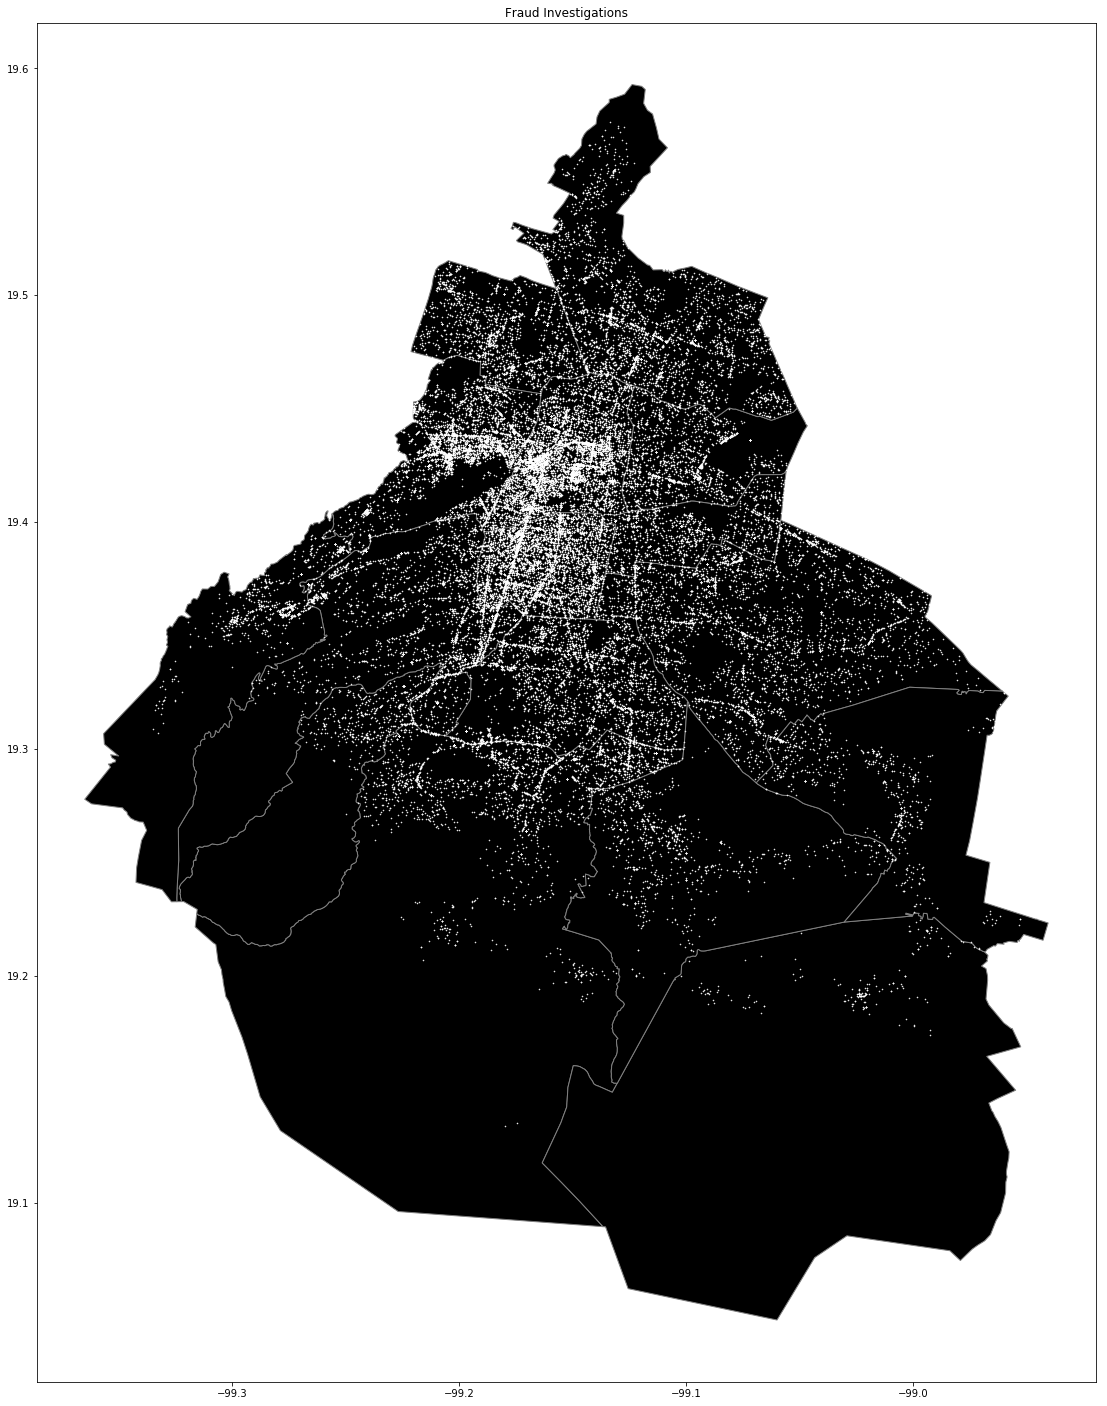

In [24]:
plt.rcParams['figure.figsize'] = (50, 25)
plt.title('Fraud Investigations')
ax = df2.plot(color='black', edgecolor='grey')

df.loc[df['delito']=='FRAUDE'].plot(ax=ax, marker='o', color='white', markersize=0.3)

In [0]:
#Cuantos crimenes hubo por alcaldia
n=df['alcaldia_hechos'].value_counts()
n['GUSTAVO A. MADERO']=n['GUSTAVO A MADERO']

#Se agregan los datos a la informacion de cada alcaldia
df2['crimen_total']=n[df2['nomgeo'].tolist()].values
df2['crimen_per_capita']=n[df2['nomgeo'].tolist()].values/pob
df2.head()

,cvegeo,nomgeo,cve_mun,cve_ent,geometry,poblacion,crimen_total,crimen_per_capita
0,09012,TLALPAN,012,09,"POLYGON ((-99.19629 19.30228, -99.19595 19.302...",677104,48711,0.071940
1,09017,VENUSTIANO CARRANZA,017,09,"POLYGON ((-99.10895 19.45273, -99.10889 19.452...",427263,48766,0.114136
2,09002,AZCAPOTZALCO,002,09,"POLYGON ((-99.18231 19.50748, -99.18229 19.507...",400161,41264,0.103118
3,09007,IZTAPALAPA,007,09,"POLYGON ((-99.05813 19.40072, -99.05814 19.400...",1827868,126807,0.069374
4,09006,IZTACALCO,006,09,"POLYGON ((-99.05584 19.42196, -99.05589 19.421...",390348,36018,0.092272


Color map with bokeh

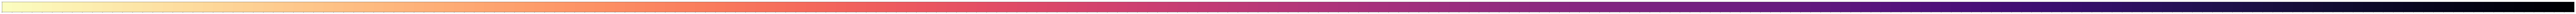

In [26]:
import seaborn as sns
#Define a color palette 
from bokeh.palettes import Magma

palette =  Magma[256]
#Order the palette inverse
palette = palette[::-1]
#LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = max(l.values))
#Add hover tool
sns.palplot(palette)

In [0]:
#Load the table
m_data = json.loads(df2.to_json())
json_data = json.dumps(m_data)
geosource = GeoJSONDataSource(geojson = json_data)

#Add hover tool
TOOLTIPS = [('Alcaldia','@nomgeo'),('Homicidios','@mrdr')]

#creates figure
p = figure(title = 'Total murder investigations',
           toolbar_location = 'right',
           tooltips = TOOLTIPS,
           sizing_mode = 'scale_width',
          background_fill_color='grey')
          

#Style considerations
p.xaxis.visible = None
p.yaxis.visible = None
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.title.align = 'center'
p.title.text_font_size = "20px"

#Draws color polygons
p.patches('xs','ys', source = geosource, fill_color = {'field':'mrdr','transform':color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Color bar
color_bar = ColorBar(color_mapper=color_mapper, width=8,  location=(0,0))
p.add_layout(color_bar, 'right')


#Image inline
output_notebook()

show(p)

In [0]:
palette =  Magma[256]
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = max(df2['mrdr_pc']))

#Add hover tool
TOOLTIPS = [('Alcaldia','@nomgeo'),('Murder', 'mrdr_pc')]

#Create figure
p = figure(title = 'Murder investigations per capita',
           toolbar_location = 'right',
           tooltips = TOOLTIPS,
           sizing_mode = 'scale_width',
          background_fill_color='grey')
          


p.xaxis.visible = None
p.yaxis.visible = None
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.title.align = 'center'
p.title.text_font_size = "20px"
#Poligons
p.patches('xs','ys', source = geosource, fill_color = {'field':'mrdr_pc','transform':color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Color bar
color_bar = ColorBar(color_mapper=color_mapper, width=8,  location=(0,0))

p.add_layout(color_bar, 'right')

#image inline
output_notebook()

show(p)

Same plots using matplotlib

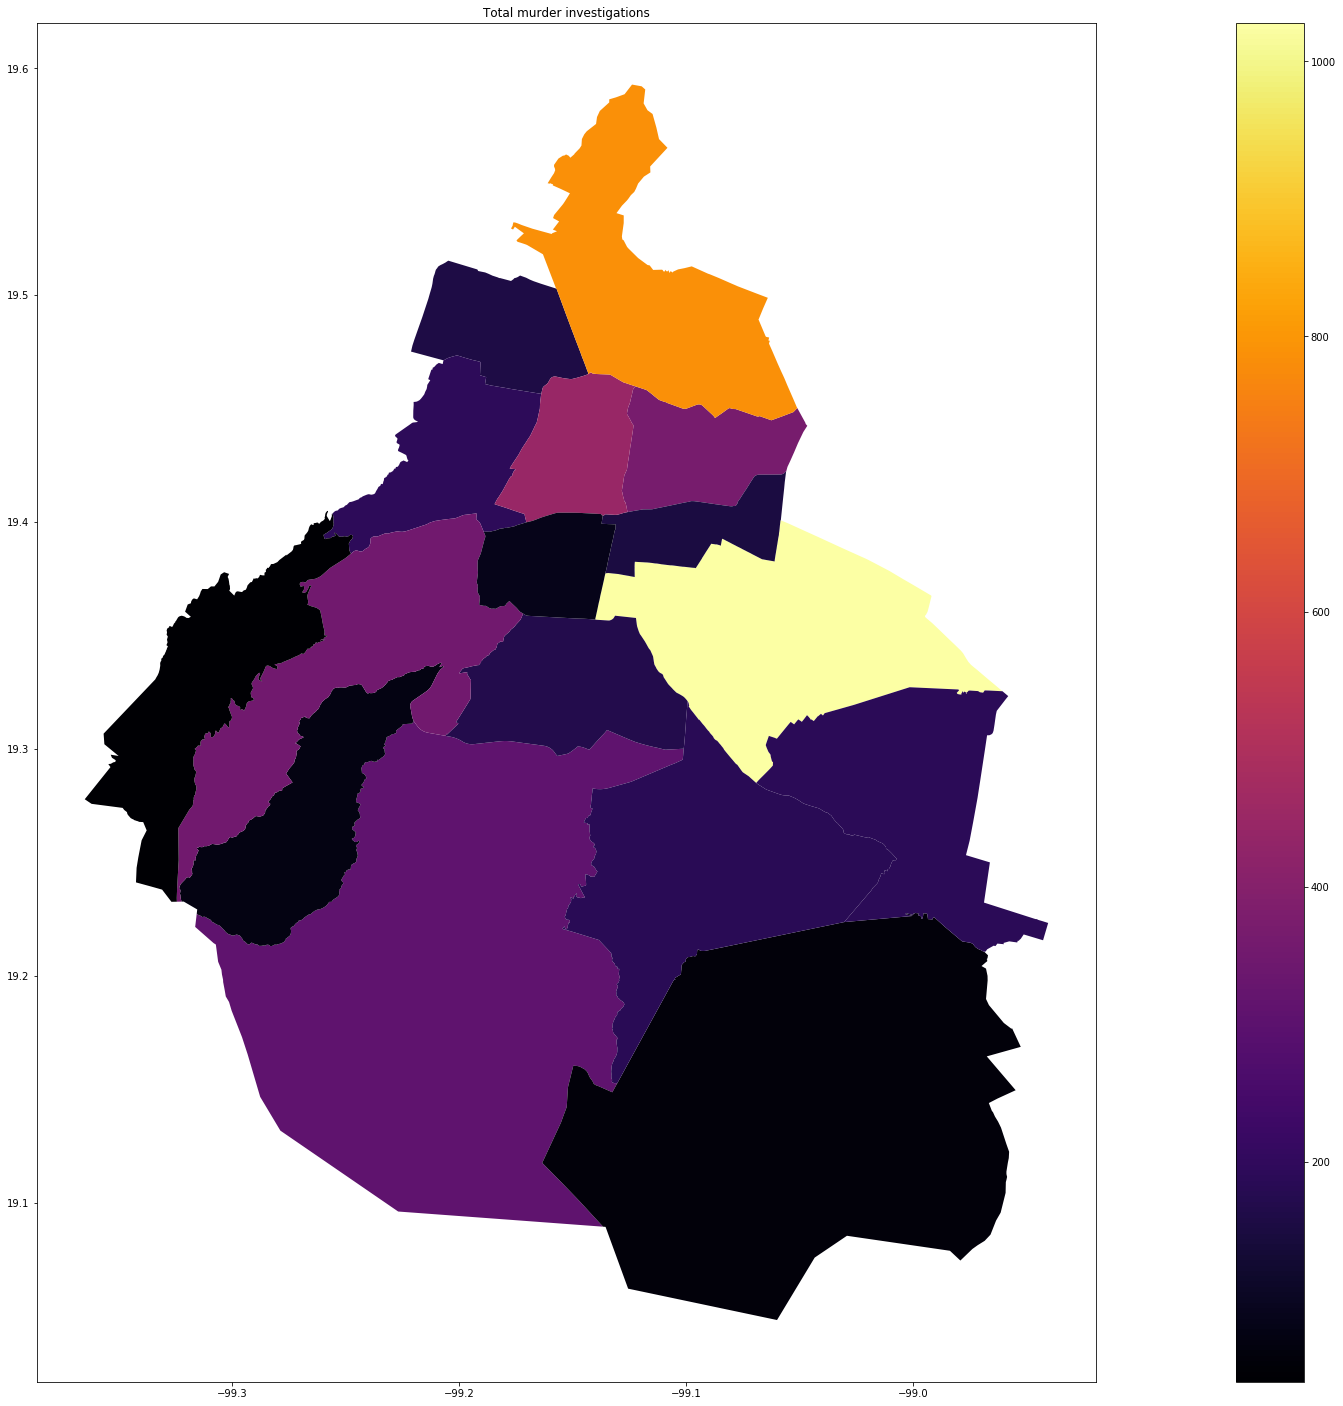

In [32]:
fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.figsize'] = (50, 25)
plt.title('Total murder investigations')
df2.plot(column='mrdr', ax=ax, legend=True, cmap='inferno')

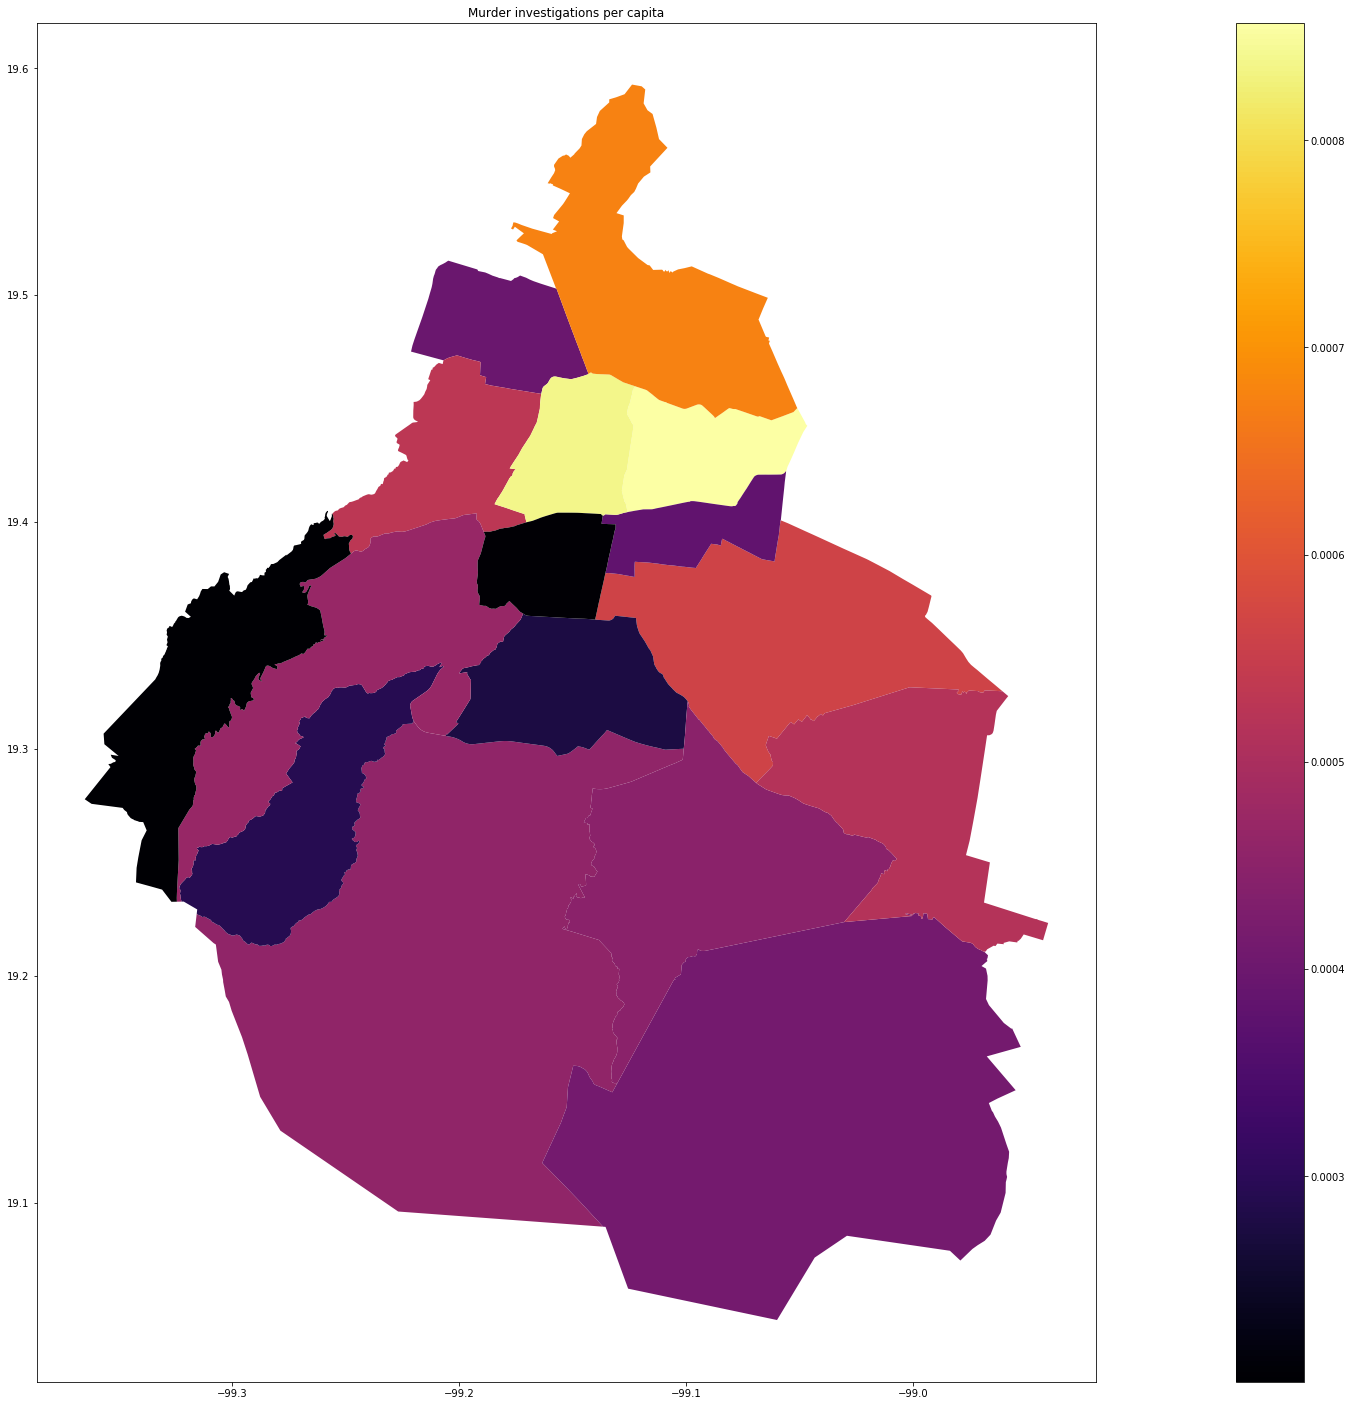

In [33]:
fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.figsize'] = (50, 25)
plt.title('Murder investigations per capita')

df2.plot(column='mrdr_pc', ax=ax, legend=True, cmap='inferno')

##Other graphs


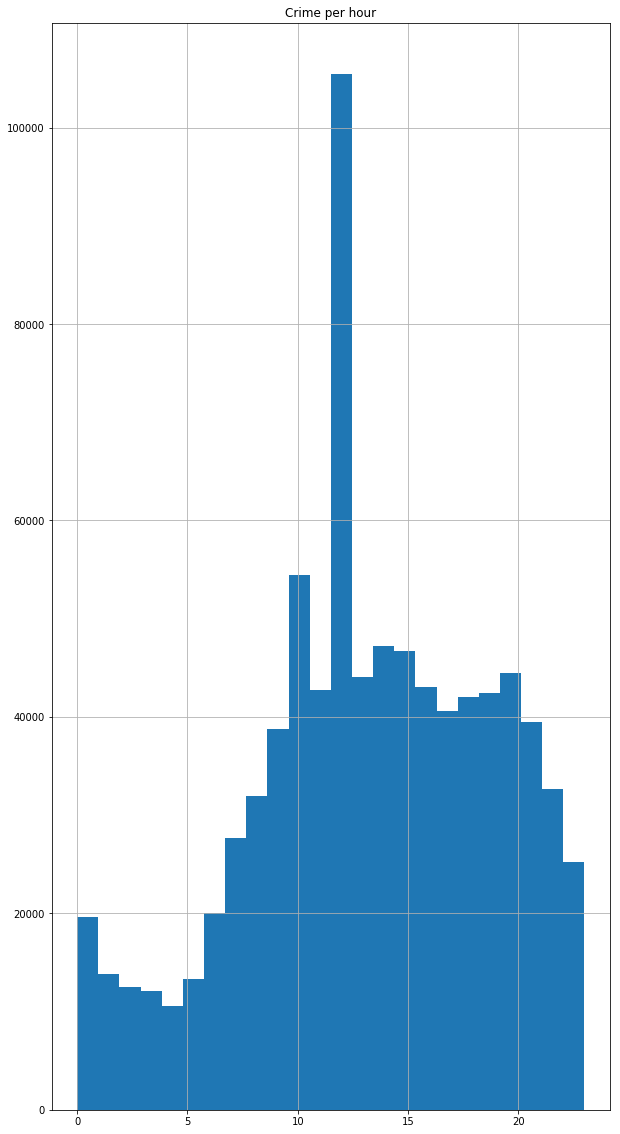

In [35]:
Fecha=df['fecha_hechos']
Fecha=Fecha.dropna()
Fecha=Fecha[np.logical_not(Fecha.str.contains('NA'))]
Fecha=Fecha.dropna()
Fecha=pd.to_datetime(Fecha, format='%Y-%m-%d %H:%M')
horas=Fecha.apply(lambda x: x.hour)
plt.rcParams['figure.figsize'] = (10, 20)
plt.title('Crime per hour')
horas.hist(bins=24)